---
# Visualization using maps in Python

---

In the Python world, there are multiple tools for data visualizing:
* [**matplotlib**](http://matplotlib.org) produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms; you can generate plots, histograms, power spectra, bar charts, errorcharts, scatterplots, etc., with just a few lines of code;
* [**Seaborn**](http://stanford.edu/~mwaskom/software/seaborn/index.html) is a library for making attractive and informative statistical graphics in Python;
* [**Bokeh**](http://bokeh.pydata.org/en/latest/) targets modern web browsers for presentation; its goal is to provide elegant, concise construction of novel graphics in the style of D3.js, but also deliver this capability with high-performance interactivity over very large or streaming datasets;
* [**plotly**](https://plot.ly) generates the most interactive graphs; allows saving them offline and create very rich web-based visualizations;
* [**folium**](http://folium.readthedocs.org/en/latest) builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the [Leaflet.js](http://leafletjs.com) JavaScript library;
* [**ggplot**](http://ggplot.yhathq.com) is built for making profressional looking, plots quickly with minimal code;
* [**pygal**](http://www.pygal.org/en/latest) features various graph types like bar charts, line charts, XY charts, pie charts, radar charts, dot charts, pyramid charts, funnel charts, gauge charts; is used for creating svg charts

and others (particularly, pandas also possesses with its own visualization funtionality). Many of above libraries contains various and powerful tools for geovisualization (using maps or globes). We will consider many examples of such visualization kind.

Among all mentioned above libraries only matplotlib is included to [Anaconda](https://www.continuum.io/). The instruction of the library instalation can be found on sites, links to which we have provided above. 

So, before going to the next paragraph, you need install _matplotlib_ (see installation guide [here](http://matplotlib.org/users/installing.html)) together with _basemap_ toolkit for matplotlib (is a library for plotting 2D data on maps in Python) (installation guide can be found [here](http://matplotlib.org/basemap/users/installing.html) and the recommendations for installing of basemap on Windows OS [here](http://stackoverflow.com/questions/18109859/how-to-install-matplotlib-basemap-module-on-windows-7-with-winpython-or-any-pyt)) and _folium_ (also pip using: `pip install folium`).

In [10]:
!sudo apt-get -y install python3-mpltoolkits.basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python3-mpltoolkits


## Datasets reading and processing data

We’ll be using route, airport, and airline data from [openflights](http://openflights.org/data.html). Each row in the route data corresponds to an airline route between two airports. Each row in the airport data corresponds to an airport in the world, and has information about it. Each row in the airline data represents a single airline. The description and signification of each column you may see [here](http://openflights.org/data.html).

In [3]:
import os
import pandas as pd

# Define folder with CSV files
data_dir = "data"

# Create a DataFrame for airports data 
airports = pd.read_csv(os.path.join(data_dir, 'airports.csv'))
print("Dataset contains {} rows.".format(len(airports.index)))
airports.head()

Dataset contains 8107 rows.


,airport_id,name,city,country,IATA_FAA,ICAO,lat,lon,altitude,timezone,dst,tz_database
0,1,Goroka,Goroka,Papua New Guinea,GKA,AYGA,-6.081689,145.391881,5282,10.0,U,Pacific/Port_Moresby
1,2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.788700,20,10.0,U,Pacific/Port_Moresby
2,3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10.0,U,Pacific/Port_Moresby
3,4,Nadzab,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569828,146.726242,239,10.0,U,Pacific/Port_Moresby
4,5,Port Moresby Jacksons Intl,Port Moresby,Papua New Guinea,POM,AYPY,-9.443383,147.220050,146,10.0,U,Pacific/Port_Moresby


In [4]:
# Create a DataFrame for airlines data
airlines = pd.read_csv(os.path.join(data_dir, 'airlines.csv'))
print("Dataset contains {} rows.".format(len(airlines.index)))
airlines.head()

Dataset contains 6048 rows.


,airline_id,name,alias,IATA,ICAO,callsign,country,active
0,1,Private flight,\N,-,NaN,NaN,NaN,Y
1,2,135 Airways,\N,NaN,GNL,GENERAL,United States,N
2,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
3,4,2 Sqn No 1 Elementary Flying Training School,\N,NaN,WYT,NaN,United Kingdom,N
4,5,213 Flight Unit,\N,NaN,TFU,NaN,Russia,N


In [5]:
# And a separate DataFrame for routes
routes = pd.read_csv(os.path.join(data_dir, 'routes.csv'))
# Some rows contain undefined `airline_id`, `source_airport_id` and `destination_airport_id`,
# which are equal to "\\N". Let's drop rows containing these value
routes = routes[(routes['airline_id'] != "\\N") & 
                (routes['source_airport_id'] != "\\N") & 
                (routes['destination_airport_id'] != "\\N")
               ]
# and change its type from `str` to `int`
for col in ['airline_id', 'source_airport_id', 'destination_airport_id']:
    routes[col] = routes[col].astype(int)
print("Dataset contains {} rows.".format(len(routes.index)))
routes.head()

Dataset contains 66548 rows.


,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


The chosen data is inherently a good fit for mapping – we have latitude and longitude pairs for airports, and for source and destination airports.

The first map we can make is one that shows all the airports all over the world. We can do this with the basemap extension to matplotlib. This enables drawing world maps and adding points, and is very customizable.

In [1]:
import mpl_toolkits.basemap

In [2]:
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
%matplotlib inline

# This defines the size of the image below
plt.rcParams['figure.figsize'] = (18, 18)
plt.style.use('seaborn-poster')

# Create a map on which to draw. We're using a `Gall Stereographic Cylindrical` projection, and showing the whole world.
# resolution: the resolution of he included coastlines, lakes, and so on. The crude resolution is chosen.
# area_thresh: the threshold under what no coast line or lake will be drawn.
# lat_0, lon_0: latitude and longitude of map center.
themap = Basemap(projection='gall', resolution = 'h', area_thresh = 10000.0, lat_0=0, lon_0=0)
 
# Draw coastlines, borders of countries and the edges of the map.
themap.drawcoastlines()
themap.drawcountries()
themap.fillcontinents(color='coral')
themap.drawmapboundary()

# Use matplotlib to draw the points onto the map.
x ,y = themap(list(airports["lon"]), list(airports["lat"]))
themap.plot(x, y, 'o', color="blue", markersize=1)

plt.show()

NameError: name 'Basemap' is not defined

The map may be more informative if we will manage markers color, shape and size.

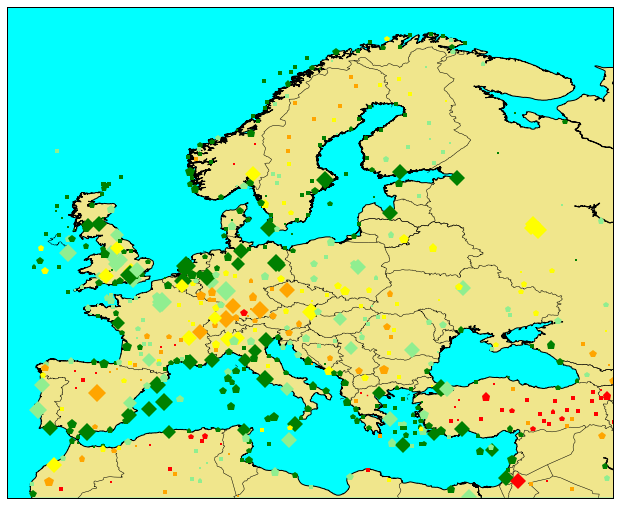

In [6]:
import math

# Define marker color depending on the altitude of airport
def get_marker_color(altitude):
    if altitude <= 200:
        return 'green'
    elif altitude <= 500:
        return 'lightgreen'
    elif altitude <= 1000:
        return 'yellow'
    elif altitude <= 2000:
        return 'orange'
    else:
        return 'red'

# Define marker size and shape based on the amount of outgoing and incoming flights of the airport 
def get_marker_size(airport_id):
    flight_count = routes[(routes['source_airport_id'] == airport_id) | (routes['destination_airport_id'] == airport_id)].shape[0]
    count = 2*math.log(flight_count+1)
    if count < 5:
        shape = 's'   # square
    elif count < 10:
        shape = 'p'   # pentagon
    elif count < 15:
        shape = 'D'   # diamond
    else:
        shape = 'o'   # circle
    return count, shape

# Zoom map on Europe
themap = Basemap(projection='gall',
                 llcrnrlon=-12,              # lower-left corner longitude
                 llcrnrlat=30,               # lower-left corner latitude
                 urcrnrlon=45,               # upper-right corner longitude
                 urcrnrlat=73,               # upper-right corner latitude
                 resolution='h',             # low resolution
                 area_thresh = 100000.0,
                )

themap.drawcoastlines()
themap.drawcountries(linewidth=0.5)
themap.fillcontinents(color='khaki')
themap.drawmapboundary(fill_color='aqua')
# Draw rivers
# themap.drawrivers(color='blue')

# Draw markers with various size and color for respective airport 
for i in airports.index.values:
    x, y = themap(airports.loc[i, "lon"], airports.loc[i, "lat"])
    size, shape = get_marker_size(airports.loc[i, "airport_id"])
    themap.plot(x, y, 
                marker=shape, 
                color=get_marker_color(airports.loc[i, "altitude"]), 
                markersize=size
               )

plt.show()

Adding of text label on the map makes it just more informative. Let's draw top 10 airports by amount of serving airlines 

In [ ]:
import numpy as np
import random

# Find ID of top `n` airports with the largest amount of airlines
def get_top_n_airports(n=10):
    gl = routes.groupby("source_airport_id")["airline_id"].apply(set).apply(len)   # `apply(set)` drops duplicates
    gl.sort_values(inplace=True, ascending=False)
    return gl[:n]


themap = Basemap(projection='robin', resolution = 'i', area_thresh = 1000.0, lat_0=0, lon_0=90)

# Display blue marble image (from http://visibleearth.nasa.gov) as map background
themap.bluemarble(scale=0.5)

# draw lat/lon grid lines every 30 degrees.
themap.drawmeridians(np.arange(0,360,30), linewidth=1, dashes=[4, 2], labels=[1,0,0,1], color='g')
themap.drawparallels(np.arange(-90,90,30), linewidth=1, dashes=[4, 2], labels=[1,0,0,1], color='g')

top = get_top_n_airports()
for _id in top.index.values:
    res = airports[airports["airport_id"] == _id][["lon", "lat", "name"]]
    x, y = themap(res['lon'].values[0], res['lat'].values[0])
    themap.plot(x, y, 'yo', markersize=top[_id] // 5)
    plt.text((1 + 0.02) * x, 
             (1 + random.choice(range(-3,3)) * 0.01) * y, 
             res['name'].values[0], color='r', fontsize=16
            )

plt.show()

Another perfect tool for vizualisation data processed in Python is `folium`. It builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library. It manipulate your data in Python, then visualize it in on a Leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing Vincent/Vega visualizations as markers on the map.

In [ ]:
!sudo pip install -U folium

In [ ]:
import folium
from IPython.display import display

# Create a map
fmap = folium.Map(location=[0, 0], zoom_start=2)

# Add markers
for name, row in airports.iterrows():
    fmap.circle_marker(location=[row["lat"], row["lon"]], 
                       popup=row["name"],                 # Popup will be shown at click on the marker
                       line_color='#3186cc', fill_color='#3186cc', radius=10000)

display(fmap)
# Try zoom and move the map

`folium` provides very detailed map and we may use it to visualize geodata localized in a small scale. Let's get the data from the [Citibike API](http://www.citibikenyc.com/stations/json):

In [ ]:
import requests
import json

url = 'http://www.citibikenyc.com/stations/json'
resp = requests.get(url)

# Transform the returned JSON answer from the API into a Python dictionary object
results = json.loads(resp.text)

# We need only a subset of the data in the JSON returned by the Citibike API, so we keep only we need
data = results["stationBeanList"]

citibike = pd.DataFrame(data)
print "Citibike dataset contains {} rows".format(citibike.size)
citibike.head()

In [ ]:
fmap = folium.Map(location=[40.73, -74], zoom_start=12)

for name, row in citibike.iterrows():
    fmap.circle_marker(location=[row["latitude"], row["longitude"]], 
                       # html formatted popup text
                       popup="<strong>Address: </strong>" + row["stAddress1"] + "<br></br>" + 
                             "<strong>Available bikes</strong>: " + str(row["availableBikes"])  + "<br></br>" + 
                             "<strong>Available docks</strong>: " + str(row["availableDocks"]),
                       line_color='yellow', fill_color='red', radius=50)

display(fmap)

In [ ]:
fmap = folium.Map(location=[40.73, -74], zoom_start=12)

# Define marker color of a station depending on `StatusValue` ('In Service' or 'Not In Service')
# and marker size depending on `availableBikes` amount
def get_color_size(row):
    # color is a tuple with (line_color, fill_color)
    color = ("green", "blue") if row["statusValue"] == 'In Service' else ("yellow", "red")
    size = row["availableBikes"]*3 + 10
    return color, size

for name, row in citibike.iterrows():
    color, size = get_color_size(row)
    fmap.circle_marker(location=[row["latitude"], row["longitude"]], 
                       # html formatted popup text
                       popup="<strong>Address: </strong>" + row["stAddress1"] + "<br></br>" + 
                             "<strong>Available bikes</strong>: " + str(row["availableBikes"])  + "<br></br>" + 
                             "<strong>Available docks</strong>: " + str(row["availableDocks"]),
                       line_color=color[0], fill_color=color[1], radius=size)

display(fmap)

It would be pretty cool to see all the air routes on a map. Luckily, we can use basemap to do this. We’ll draw great circles connecting source and destination airports. Each circle will show the route of a single airliner. Unfortunately, there are so many routes that showing them all would be a mess. Instead, we’ll show the first 2000 routes.

In [ ]:
themap = Basemap(projection='robin', resolution = 'c', area_thresh = 10000.0, lat_0=0, lon_0=-90)
 
themap.fillcontinents(color='lightgray', lake_color='lightblue')
themap.drawmapboundary(fill_color='lightblue')
themap.drawcountries()
themap.drawcoastlines()

# Iterate through the first 2000 rows
for name, row in routes[:2000].iterrows():
    try:
        # Get the source and destination airports
        source = airports[airports["airport_id"] == row["source_airport_id"]].iloc[0]
        dest = airports[airports["airport_id"] == row["destination_airport_id"]].iloc[0]
        # Draw a great circle between source and dest airports
        themap.drawgreatcircle(source["lon"], source["lat"], 
                               dest["lon"], dest["lat"],
                               linewidth=1, color='b')
    except (ValueError, IndexError):
        pass

plt.show()

IPython Notebook provides wonderfull tools `widgets` for managing of displayed results. We will use this functional to write the code, wich will draw a new map with routes between source airport (this airport you will select yourself by typing its name or id in special text field) and all destignation airports. But let's consider before a few examples demonstrating the usage of `widgets`.

In [ ]:
# Example 1
from ipywidgets import interact

def f(x):
    print "Move slider to change this {} text".format(x)

interact(f, x=10)

In [ ]:
from IPython.display import clear_output

x = np.arange(0, 2*np.pi, 0.001)

def plot_sin_cos(amplitude, period):
    plt.plot(x, amplitude * np.sin(2*np.pi*x*period), 'r-')
    plt.plot(x, np.cos(2*np.pi*x*period), 'b--')
    clear_output(wait=True)
    display(plt.show())
    
interact(plot_sin_cos, amplitude=(0.1, 5.0, 0.1), period=(0.1, 5.0, 0.1))

In [ ]:
# Example 2
from ipywidgets import widgets 

print 'This element contains uppercased text from the bottom text element.'
# Display the text widget
outputText = widgets.Text()  
outputText

In [ ]:
def uppercase(sender):
    outputText.value = inputText.value.upper()
    
print 'Type some text here and it will appear in upper text element and "Enter" clicking.'
# Display the text widget
inputText = widgets.Text()
# Add event listener which activates at "Enter" clicking
inputText.on_submit(uppercase)
inputText

In [ ]:
# Example 3
def on_button_clicked(event):
    # transform a text to its palindrome
    text.value = text.value[::-1]
    
# Display the text widget
text = widgets.Text(description="Type some text here:", width=200)  
display(text)

#add button that updates the graph based on the checkboxes
button = widgets.Button(description="Transform input text")
display(button)

# Add event listener which activates at click on button
button.on_click(on_button_clicked)  

In [ ]:
# And now we may implement our plan about updated map
def get_routes_for_airport(sender):
    # Draw the map
    themap = Basemap(projection='robin', resolution = 'c', area_thresh = 10000.0, lat_0=0, lon_0=10)
    themap.fillcontinents(color='lightgray', lake_color='lightblue')
    themap.drawmapboundary(fill_color='lightblue')
    themap.drawcountries()
    themap.drawcoastlines()

    text = inputAirportIdentificator.value.lower()
    # Check if ID was typed
    try:
        text = int(text)
    except ValueError:
        pass
    
    # Find the airport by ID or `name`
    if isinstance(text, int):
        source = airports[airports["airport_id"] == text].iloc[0]
        condition = lambda row: row["source_airport_id"] == text
    else:
        source = airports[airports["name"].apply(lambda x: x.lower()) == text].iloc[0]
        text = source['airport_id']
    
    # If there are more then one the same source and destination airports
    # we won't draw this trajectory again
    exist = []
    
    # Find all destination airports where source airport is `source`
    for name, row in routes.iterrows():
        if row["source_airport_id"] == text and row['destination_airport_id'] not in exist:
            try:
                # Get the destination airport
                dest = airports[airports["airport_id"] == row["destination_airport_id"]].iloc[0]
                # Draw a great circle between source and dest airports.
                themap.drawgreatcircle(source["lon"], source["lat"], 
                                       dest["lon"], dest["lat"],
                                       linewidth=1, color='b'
                                      )
                exist.append(row['destination_airport_id'])
            except (ValueError, IndexError):
                pass
    
    # Delete the previous map if it is build
    clear_output(wait=True)
    display(plt.show())

inputAirportIdentificator = widgets.Text(description="Type airport name or ID:", width=400) 
display(inputAirportIdentificator)
inputAirportIdentificator.on_submit(get_routes_for_airport)

Often very informative geovisualization can be reached with the help of globes. `basemap` also provides the possibility of the globe using. Let's build an interactive rotating globe where we random 100 airports with the help of markers. 

In [ ]:
import numpy as np

# Random choice of 100 rows from `airports` DataFrame 
array = []
for i, row in airports.sample(100).iterrows():
    array.append((row['lon'], row['lat']))
    
# Change the size of the image for globe
plt.rcParams['figure.figsize'] = (8, 8)

def globe(lon, lat):
    themap = Basemap(projection='ortho', lon_0=lon, lat_0=lat, resolution='c', area_thresh=10000.0)
    
    themap.drawcoastlines()
    themap.fillcontinents(color='coral', lake_color='lightblue')
    themap.drawparallels(np.arange(-80.,81.,20.))
    themap.drawmeridians(np.arange(-180.,180.,20.))
    themap.drawmapboundary(fill_color='lightblue')
    themap.drawcountries()
    
    # Add markers
    for i in array:
        x, y = themap(i[0], i[1])
        themap.plot(x, y, 'o', color="blue", markersize=8)
    
    plt.title("Rotatable globe")
    clear_output(wait=True)
    display(plt.show())
    
interact(globe, lon=(-180,180,1), lat=(-90,90,1))

---
## Exercises
---

## Exercise #1: 

> `basemap`'s method `shadedrelief(scale=0.1, origin='lower')` allows drawing maps with Earth relief. Note, attributes in brackets correspond to minimal performance requirements. Find TOP 10 airports wich are situated on the greatest height and TOP 10 airports with the lowest altitude. Display the list of this airports showing its name and country. Also draw the map of Miller projection (`projection="mill"`) using `shadedrelief()` method and show these airports using colored markers. The marker's color depends on the airport's altitude and can be defined with the help of `get_marker_color(altitude)` function which we have used earlier. Marker's size is 10 units. As result, you should get the map like this:

> <img src="images/ex1.png">

## Exercise #2: 

> `routes` DataFrame contains many routes between two airports. Let's caclulate its lengths and draw, for example, 10 the longest of them trajectories on the map (you may choice projection, resolution, etc. yourself). 

>In order to do this, you need to first calculate route lengths. We may use [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula), which calculates the distance between latitude, longitude pairs (in our case, between latitude and longitude values of source and destination airports):
$$d = 2 r \arcsin\left(\sqrt{\sin^2\left(\frac{\varphi_2 - \varphi_1}{2}\right) + \cos(\varphi_1) \cos(\varphi_2)\sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right),$$
$\varphi_1$ and $\varphi_2$: latitude of point 1 and latitude of point 2; <br></br>
$\lambda_1$ and $\lambda_2$: longitude of point 1 and longitude of point 2; <br></br>
let's consider the average Earth radius $r$ is equal to 6367 km. 

## Exercise #3: 

> Find TOP 10 countries with the largest and the lowest amounts of airports on their territory and show all airports of these countries using markers on the `folium` map. Circle markers correspond to TOP 10 countries with the largest amount and diamond markers define TOP 10 countries with the lowest amount of airports. Red markers should denote the airports which have no connections with some others, i.e. thay are absent in `routes` DataFrames; blue markers correspond to all others. Marker's size is fixed and equals, for example, to 1000.